#Mouse celseq1 organoid data were collected from GSE62270 and processed with kallisto bus

kallisto bus -i index/Mus_musculus.GRCm38.cdna.all.fa.kidx -x CELSeq -t 8 -o kallisto_Organoid_out/L001/ \ celseq1/Organoid1_GSE62270_L001_R1.fastq celseq1/Organoid1_GSE62270_L001_R2.fastq

bustools sort -t 8 -o kallisto_Organoid_out/L001/output.sort.bus kallisto_Organoid_out/L001/output.bus

bustools dump -o kallisto_Organoid_out/L001/output.sort.txt kallisto_Organoid_out/L001/output.sort.bus
#Change L001 to L00X, X in {1,7} to process data from all 96 wells.

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import sys, collections

#Load celseq1 kallisto bus results (L001 to L007) to generate gene count tables. Change L007 to L00X x in {1, 7} to process the bus results. 

In [3]:
#load mouse transcript

tr2g = {}
trlist = []
with open('/home/fgao/Data_single_cell/kallisto_benchmark/index/tr2g_mouse') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('/home/fgao/Data_single_cell/kallisto_benchmark/kallisto_Organoid_out/L007/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

In [4]:
# load test dataset

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('/home/fgao/Data_single_cell/kallisto_benchmark/kallisto_Organoid_out/L007/output.sort.txt') as f:
    gs = set()
    gl_sum=[]
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's add new genelist of existing genelist
                gl = ec2g(ec)
                gl_sum = gl_sum + gl
            else:
                # new UMI, process the previous gene set
                gs = set(gl_sum)
                g_max = max(gl_sum, key=gl_sum.count)
                for i in set(gl_sum):
                    if (gl_sum.count(i) < gl_sum.count(g_max)):
                        gs.remove(i)
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gl_sum = ec2g(ec)
        else:
            # bypass the first bus record
            if (gl_sum == []):
                pbar = barcode
                pumi = umi
                gl_sum = ec2g(ec)
            else:
                # work with previous gene list
                gs = set(gl_sum)
                g_max = max(gl_sum, key=gl_sum.count)
                for i in set(gl_sum):
                    if (gl_sum.count(i) < gl_sum.count(g_max)):
                        gs.remove(i)
                for g in gs:
                    cell_gene[pbar][g] += 1.0/len(gs)
            
                if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                    del cell_gene[pbar]
                pbar = barcode
                pumi = umi         
                gl_sum = ec2g(ec)
    #remember the last gene
    gs = set(gl_sum)
    g_max = max(gl_sum, key=gl_sum.count)
    for i in set(gl_sum):
        if (gl_sum.count(i) < gl_sum.count(g_max)):
            gs.remove(i)
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]



In [5]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s
    

In [6]:
whitelist = set(x.strip() for x in open('/home/fgao/Data_single_cell/kallisto_benchmark/kallisto_Organoid_out/BC.txt'))

96


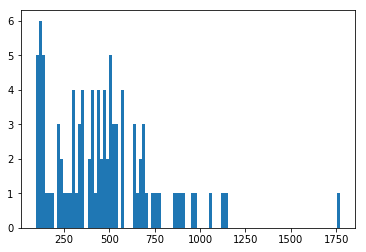

In [7]:
bcv = [x for b,x in barcode_hist.items() if x > 0 and b in whitelist]
_ = plt.hist(bcv,bins=100)
print(len(bcv))

In [8]:
outfile = '/home/fgao/Data_single_cell/kallisto_benchmark/kallisto_Organoid_out/L007/matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 0 and b in whitelist]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])



In [9]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))
    

In [10]:
gene_names = {}
with open('/home/fgao/Data_single_cell/kallisto_benchmark/index/mart_export_mouse.txt') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


In [11]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('/home/fgao/Data_single_cell/kallisto_benchmark/kallisto_Organoid_out/L007/genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('/home/fgao/Data_single_cell/kallisto_benchmark/kallisto_Organoid_out/L007/barcodes.tsv','w') as of:
    of.write('\n'.join(x + '' for x in barcodes_to_use))
    of.write('\n')

In [12]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '/home/fgao/Data_single_cell/kallisto_benchmark/kallisto_Organoid_out/kallisto_Organoid.h5ad'
sc.settings.set_figure_params(dpi=80)

adata1 = sc.read_10x_mtx('../kallisto_Organoid_out/L001/', var_names='gene_symbols', cache=False)
adata2 = sc.read_10x_mtx('../kallisto_Organoid_out/L002/', var_names='gene_symbols', cache=False)
adata3 = sc.read_10x_mtx('../kallisto_Organoid_out/L003/', var_names='gene_symbols', cache=False)
adata4 = sc.read_10x_mtx('../kallisto_Organoid_out/L004/', var_names='gene_symbols', cache=False)
adata5 = sc.read_10x_mtx('../kallisto_Organoid_out/L005/', var_names='gene_symbols', cache=False)
adata6 = sc.read_10x_mtx('../kallisto_Organoid_out/L006/', var_names='gene_symbols', cache=False)
adata7 = sc.read_10x_mtx('../kallisto_Organoid_out/L007/', var_names='gene_symbols', cache=False)
adata = adata1.concatenate(adata2, adata3, adata4, adata5, adata6, adata7, join='outer')

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [13]:
adata.write_csvs('../kallisto_Organoid_out/', skip_data=False)

In [14]:
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

filtered out 338 cells that have less than 100 genes expressed
filtered out 33975 genes that are detected in less than 2 cells


In [15]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata

View of AnnData object with n_obs × n_vars = 334 × 2146 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'n_cells'

In [16]:
adata = adata[adata.obs['percent_mito'] < 0.2, :]
adata

View of AnnData object with n_obs × n_vars = 307 × 2146 
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'n_cells'

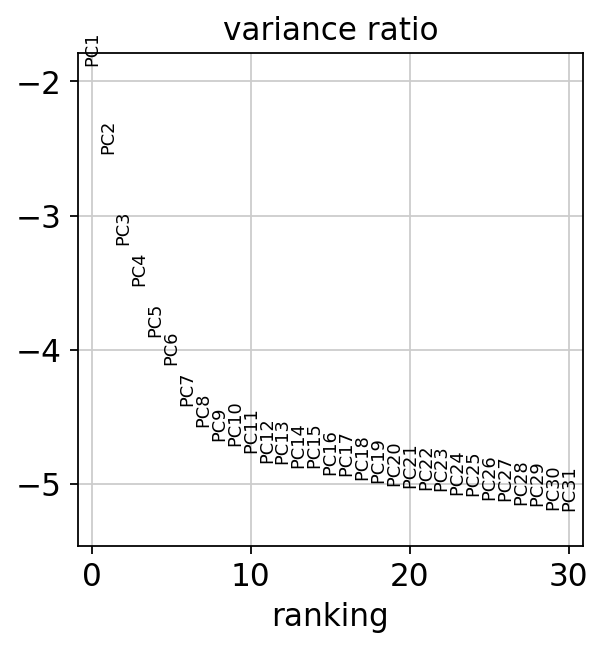

In [17]:
#adata.raw = adata
sc.pp.log1p(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:05.40) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:01.51) --> added
    'X_umap', UMAP coordinates (adata.obsm)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.03) --> found 7 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


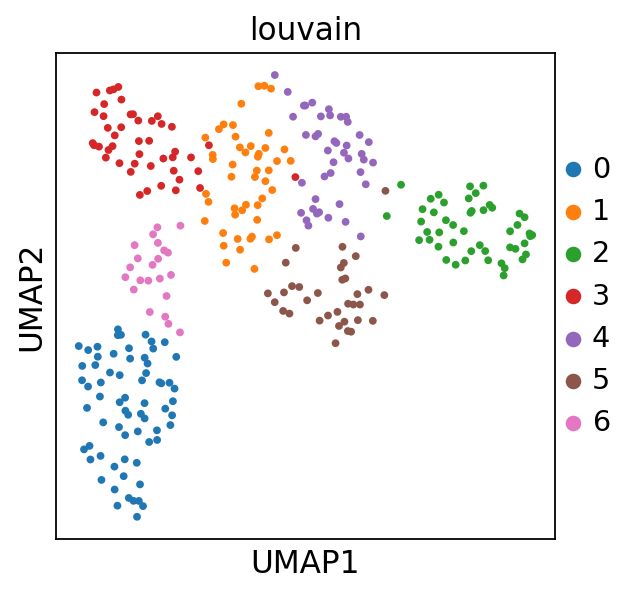

In [19]:
sc.tl.louvain(adata, resolution=1)
sc.pl.umap(adata, color=['louvain'], size=25)

computing tSNE
    using 'X_pca' with n_pcs = 30
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:07.35) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


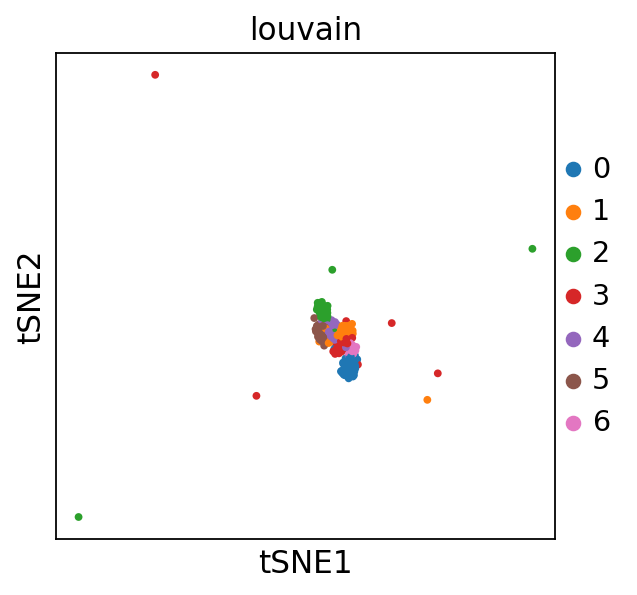

In [20]:
sc.tl.tsne(adata, n_pcs=30)
sc.pl.tsne(adata, color=['louvain'], size=25)

In [21]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test', corr_method='benjamini-hochberg')

ranking genes
    finished (0:00:00.13) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [22]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
#pd.DataFrame({group + '_' + key: result[key][group]
#    for group in groups for key in ['names', 'scores','logfoldchanges','pvals','pvals_adj']}).head(5)

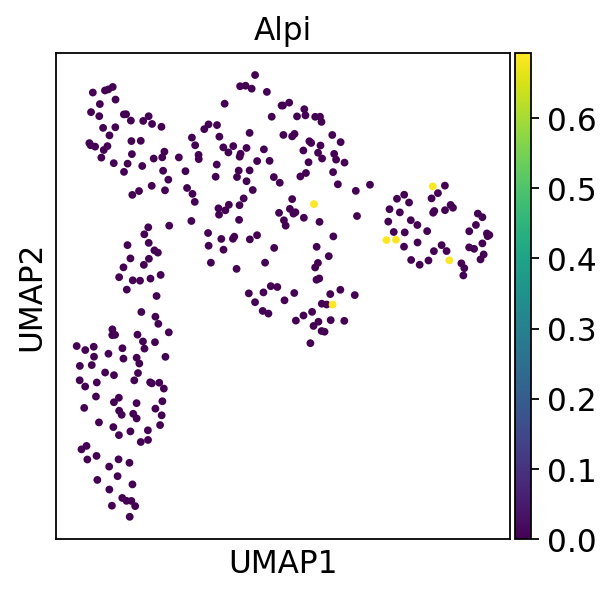

In [23]:
marker_genes = ['Alpi']
#marker_genes[0]
sc.pl.umap(adata, color=marker_genes[0], size=25)